# Curie Temperature in the Ising model

<code>Code from:</code> Session 12.1 by Prof. C. Scheffler

In [1]:
def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt


class IsingSimulation:

    J = 6.34369e-21  # Interaction constant for iron [Joule]
    kB = 1.38065e-23  # Boltzmann constant [Joule / Kelvin]

    def __init__(self, size=100, temperature=300, speedup=None):
        '''
        Initialize a new Ising simulation.

        Parameters:

            size (int) The number of cells along each side of the
              square grid. Default: 100.

            temperature (float) The temperature at which to run the
              simulation, measured in Kelvin. The Curie temperature
              of iron is at 1043 K. Default: 300 (approximately room
              temperature).

            speedup (int) The number of cell flips to do per call to
              the update() method. Default: size ** 2.
        '''
        self.size = size
        self.temperature = temperature
        if speedup is None:
            speedup = self.size ** 2
        self.speedup = speedup

        # Set random initial state
        self.state = np.random.choice(
            [-1, 1], size=(self.size, self.size))
        self.step = 0
        self.history = {
            'step': [],
            'magnetism': []}

    def update(self):
        # Flip the signs of self.speedup cells
        for _ in range(self.speedup):
            # Pick a random cell to flip
            x, y = np.random.randint(self.size, size=2)
            # Change in energy from current state to next state if we flip
            delta_E = (
                2 * self.J * self.state[x, y] * (
                    self.state[(x + 1) % self.size, y] +
                    self.state[(x - 1) % self.size, y] +
                    self.state[x, (y + 1) % self.size] +
                    self.state[x, (y - 1) % self.size]))
            # Log probability of changing state
            log_p = -delta_E / (self.temperature * self.kB)
            # Flip cell with probability exp(log_p)
            if np.log(np.random.uniform(0, 1)) < log_p:
                self.state[x, y] = -self.state[x, y]

        self.step += self.speedup
        self.history['step'].append(self.step)
        self.history['magnetism'].append(self.state.mean())

    def display_state(self):
        # Plot current state
        plt.imshow(self.state, vmin=-1, vmax=+1)
        plt.title('Step: ' + str(self.step))

    def display_history(self):
        # Plot history of average magnetism
        step = np.array(self.history['step'])
        for y in [-1, 0, 1]:
            plt.plot([step[0], step[-1]], [y, y], 'k:')
        plt.plot(step, self.history['magnetism'], 'k-')
        plt.xlabel('step')
        plt.ylabel('average magnetism')
        plt.title('Temperature: ' + str(self.temperature) + ' K')

In [22]:
def ising_gif_animation(temperature, size, frames, steps_per_frame):
    sim = IsingSimulation(size, temperature, speedup=steps_per_frame)

    def animate(frame, total_frames):
        sim.update()
        sim.display_state()
        
    animation = make_animation(
        animate, frames=frames, interval=10000 // frames,
        verbose=True, figure_params={'figsize': (10, 10)})
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    sim.display_history()
    plt.subplot(1,2,2)
    sim.display_state()

    return animation

In [23]:
def ising_animation(temperature, size, frames, steps_per_frame):
    sim = IsingSimulation(size, temperature, speedup=steps_per_frame)
    for i in range(frames):
        sim.update()
        sim.display_state()
    sim.display_history()

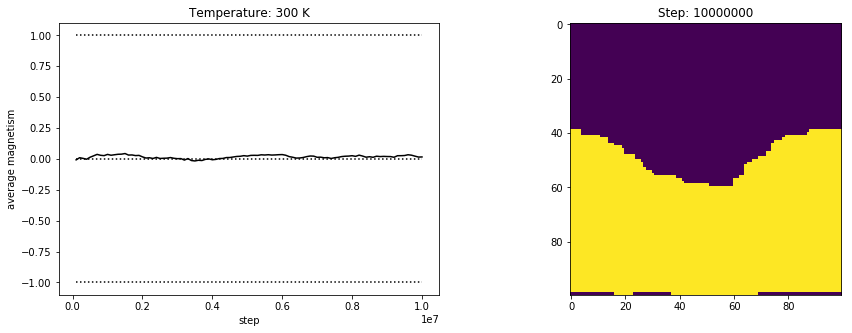

In [25]:
ising_gif_animation(temperature=300, size=100, frames=100, steps_per_frame=10**5)

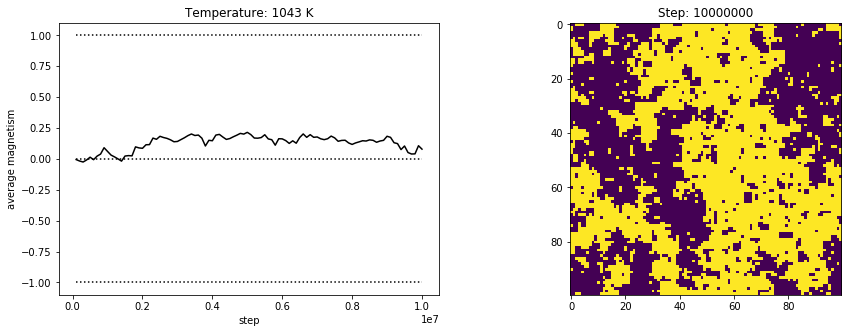

In [26]:
ising_gif_animation(temperature=1043, size=100, frames=100, steps_per_frame=10**5)

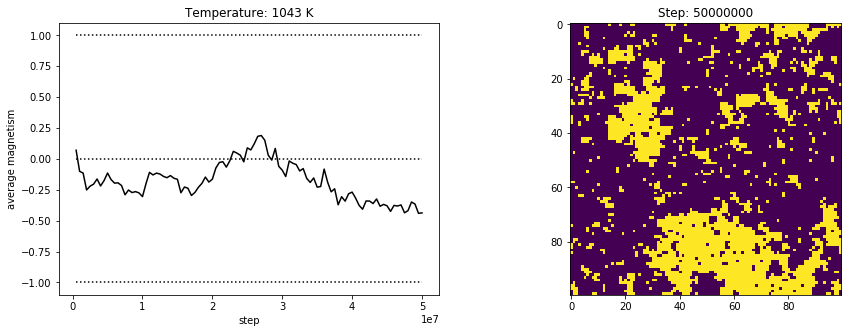

In [27]:
ising_gif_animation(temperature=1043, size=100, frames=100, steps_per_frame=5*10**5)

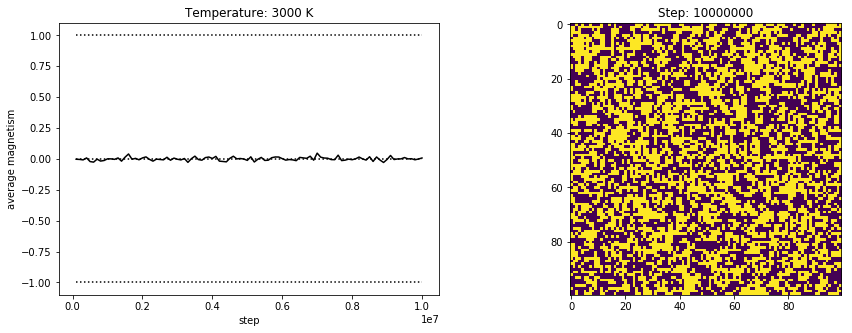

In [28]:
ising_gif_animation(temperature=3000, size=100, frames=100, steps_per_frame=10**5)